In [2]:
# Import functions 
import sys
sys.path.insert(0, '..')
from racecar_utils import *   

In [3]:
# Start ROS Node
rospy.init_node('racecar')
rc = Racecar()
print('ROS node started successfully')

ROS node started successfully


In [4]:
#draws rectangle over frame to crop
def crop(img):
    cv2.rectangle(img, UPPER_LEFT_COORD, LOWER_RIGHT_COORD, (0, 0, 0), -1) 
    return img

In [20]:
# constants 
UPPER_LEFT_COORD = (0, 300)
LOWER_RIGHT_COORD = (639, 0)
CONE_HSV_LOWER = np.array([0, 135, 180])
CONE_HSV_UPPER = np.array([10, 255, 255])
HSV_LOWER = np.array([45, 45, 75])
HSV_UPPER = np.array([60, 220, 170])
SCREEN_CENTER = 415
TURN_FACTOR = 20  # used to be 0.5
DRIVE_SPEED = .195
VIDEO = True
VIDEO_LIMIT = 5
MIN_SIZE = 12000
MAX_SIZE = 20000
EXIST_SIZE = 350   

In [6]:
def get_angle(contour_center):
    max_angle = -abs(TURN_FACTOR) 
    error = contour_center - float(SCREEN_CENTER)
    ratio = error/SCREEN_CENTER
    angle = ratio*max_angle 
    return angle

In [7]:
def line_following(frame):
    print("following line")
    frame = crop(frame) #draws rectangle over frame to crop
    # TASK #1: Convert frame from BGR to HSV
    img_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # TASK #2: Mask the image via HSV_LOWER and HSV_LOWER
    mask = cv2.inRange(img_hsv, HSV_LOWER, HSV_UPPER)
    # TASK #3: Find the contours
    contours = cv2.findContours(mask, 3, 2)[1]
    # if contours exist, get the center of the largest contour
    if len(contours) > 0:
        greatest_contour = max(contours, key = cv2.contourArea) # get largest contour
        M = cv2.moments(greatest_contour)
        if M['m00'] != 0:
            x, y = int(M['m10'] / M['m00']), int(M['m01'] / M['m00'])
            contour_center = x
            # TASK #5: Draw all the contours 
            cv2.drawContours(frame, contours, -1, (0, 255, 0), 2)
            # TASK #6: Draw a circle at the contour center
            cv2.circle(frame, (x, y), 10, (255, 0, 0), -1)
            # show image
            show_frame(frame)
            # TASK #7: Call 'get_angle', giving it 'contour_center' as the argument
            angle = get_angle(contour_center)
            # TASK #8: Call 'rc.drive', with parameters: 'DRIVE_SPEED' and 'angle'
            rc.drive(DRIVE_SPEED, angle)

In [8]:
def get_speed(area):
    # TASK #1: Get the contour area of 'contour'
    if area > MAX_SIZE:
        return -DRIVE_SPEED
    elif area < MIN_SIZE:
        return DRIVE_SPEED
    return 0
def get_angle_cone(contour_center, speed):
    max_angle = -abs(TURN_FACTOR) 
    if speed < 0:
        max_angle = abs(TURN_FACTOR) 
    error = contour_center - float(SCREEN_CENTER)
    ratio = error/SCREEN_CENTER
    angle = ratio*max_angle 
    return angle

In [9]:
TURN_SPEED = .12
TURN_ANGLE = 15
TURN_TIME = .75

In [16]:
def cone_following(frame):
    img_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img_hsv, CONE_HSV_LOWER, CONE_HSV_UPPER)
    contours = cv2.findContours(mask, 3, 2)[1]
    if len(contours) > 0:
        greatest_contour = max(contours, key = cv2.contourArea) # get largest contour
        gr_area = cv2.contourArea(greatest_contour)
        print(gr_area)
        if gr_area <= EXIST_SIZE:
            return False 
        M = cv2.moments(greatest_contour)
        if M['m00'] != 0:
            contour_center = int(M['m10'] / M['m00'])
            # TASK #5: Draw all the contours 
            cv2.drawContours(frame, contours, -1, (0, 255, 0), 2)
            # show image
            show_frame(frame)
            # print("cone found")
            # TASK #7: Call 'get_angle', giving it 'contour_center' as the argument
            speed = get_speed(cv2.contourArea(greatest_contour))
            angle = get_angle_cone(contour_center, speed)
            print(speed, angle)
            rc.drive(speed, angle)
            if speed == 0:
                rc.drive(TURN_SPEED, TURN_ANGLE)
                rc.pub_drive.publish(rc.last_drive)
                time.sleep(TURN_TIME)
                rc.drive(TURN_SPEED, -TURN_ANGLE)
                rc.pub_drive.publish(rc.last_drive)
                time.sleep(TURN_TIME+.5)
            return True
    return False

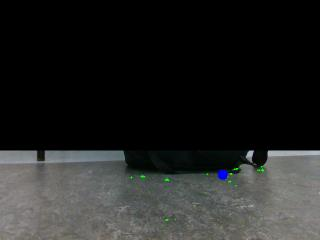

In [18]:
show_image(crop)

In [ ]:
# setup display
display = IPython.display.display('', display_id=1)

def together(img):
#     coneFound = cone_following(img)
#     print(coneFound)
    if not cone_following(img):
        line_following(img)

# run the line_following function!
rc.run(together, 100)

''

following line
following line
following line
following line
following line
following line
following line
following line
following line
following line
following line
0.0
following line
0.0
following line
0.0
following line
0.5
following line
0.0
following line
0.5
following line
1.0
following line
1.0
following line
2.5
following line
1.0
following line
3.5
following line
1.5
following line
1.5
following line
3.0
following line
2.5
following line
2.0
following line
2.5
following line
1.0
following line
2.0
following line
1.0
following line
1.0
following line
5.5
following line
5.5
following line
3.0
following line
1.5
following line
3.5
following line
1.0
following line
1.0
following line
0.5
following line
0.5
following line
0.5
following line
0.0
following line
0.0
following line
following line
following line
following line
0.0
following line
0.0
following line
following line
following line
following line
following line
0.0
following line
following line
0.0
following line
following li

## Step 6: Parameter Tuning

<p style='font-size:1.75rem;line-height:1.5'>
    Tune the following parameters to improve your line follower!
    <ul style='font-size:1.75rem;line-height:1.5'>
        <li><code>UPPER_LEFT_COORD</code> and <code>LOWER_RIGHT_COORD</code>: to adjust the crop size view area</li>
        <li><code>HSV_LOWER</code> and <code>HSV_UPPER</code>: to adjust the threshold color</li>
        <li><code>SCREEN_CENTER</code>: to adjust for screen center offset</li>
        <li><code>TURN_FACTOR</code>: for the turn intensity of the car</li>
        <li><code>DRIVE_SPEED</code>: for the speed of the car</li>
    </ul>
    </p>

# Line Following Competition!!!!!!

<p style='font-size:1.75rem;line-height:1.5'>
    We have prepared a race track, where we will compete against other teams to finish the course in the shortest time AND follow the line with most elegance.
    </p>

<p style='font-size:1.75rem;line-height:1.5'>
    Each judge will rank teams (<code>1</code> - <code>10</code>) based on: time, speed, accuracy, and elegance.
    </p>
    

<p style='font-size:1.75rem;line-height:1.5'>
    The final score is:
    </p>
    
```python
score = judges_total_score - (time / 2)
```